In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.numpy_encode import stream2npenc_parts

# Generate Music with Pretrained Model

How to generate remix melody but keeping the chord progression and melody rhythm the same  
https://github.com/bearpelican/musicautobot/issues/8

### Load Pretrained

In [4]:
# Config
config = multitask_config();

# Location of your midi files
midi_path =  Path('data/midi')

# Location of saved datset
data_path = Path('data/numpy')
data_save_name = 'musicitem_data_save.pkl'

In [5]:
# Data
data = MusicDataBunch.empty(data_path)
vocab = data.vocab

In [6]:
# Pretrained Model

# Download pretrained model if you haven't already
pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MultitaskSmallKeyC.pth'
# pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MultitaskSmall.pth'

pretrained_path = data_path/'pretrained'/Path(pretrained_url).name
download_url(pretrained_url, dest=pretrained_path)

In [7]:
# Learner
learn = multitask_model_learner(data, pretrained_path=pretrained_path)
# learn.to_fp16();

### Choose existing midi file as a starting point

In [8]:
example_dir = midi_path/'examples'
midi_files = get_files(example_dir, recurse=True, extensions='.mid'); midi_files[:5]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid'),
 PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid')]

In [9]:
file = midi_files[3]; file

PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid')

In [10]:
# Encode file 
item = MusicItem.from_file(file, data.vocab)

x = item.to_tensor()
x_pos = item.get_pos_tensor()

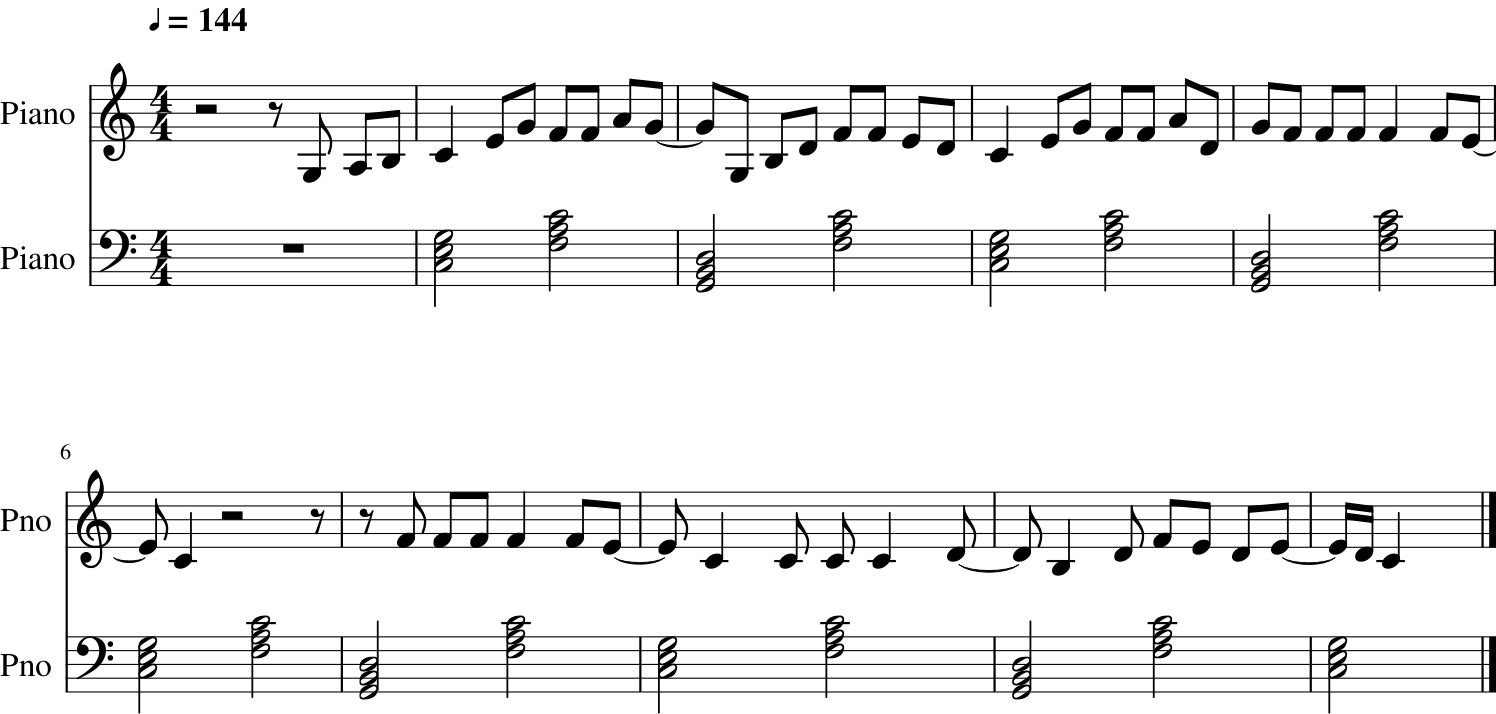

In [84]:
item.show()

In [ ]:
item.play()

## 2. Mask/Remix Melody Only

In [52]:
file

PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid')

In [53]:

def chordarr2npenc(chordarr, skip_last_rest=True, **kwargs):
    # combine instruments
    result = []
    wait_count = 0
    for idx,timestep in enumerate(chordarr):
        flat_time = timestep2npenc(timestep, **kwargs)
        if len(flat_time) == 0:
            wait_count += 1
        else:
            # pitch, octave, duration, instrument
            if wait_count > 0: result.append([VALTSEP, wait_count, -1])
            result.extend(flat_time)
            wait_count = 1
    if wait_count > 0 and not skip_last_rest: result.append([VALTSEP, wait_count, -1])
    if len(result) == 0: return np.empty(shape=(0, 2), dtype=int) # reshaping array if result is empty
    return np.array(result, dtype=int)

In [55]:

stream = file2stream(file) # 1.
chordarr = stream2chordarr(stream) # 2.
npenc = chordarr2npenc(chordarr, enc_type='parts') # 3.

In [59]:
npenc.shape

(160, 3)

In [90]:
# Mask Index (before idxencoding)
premask_idx = vocab.mask_idx - vocab.note_range[0]

In [91]:
npenc.shape # timesteps x (note, duration, track/part)

(160, 3)

In [94]:
# Set melody notes  to mask_idx
track_0 = npenc[:, 2] == 0
note_col = 0
npenc[track_0, note_col] = premask_idx # (:, 

In [95]:
npenc_2col = npenc[:, :2]; npenc_2col.shape

(160, 2)

In [78]:
mask_melody_idxenc = npenc2idxenc(twocol_npenc, vocab) # encode to single stream array

In [97]:
mItem = MusicItem(mask_melody_idxenc, vocab=vocab); mItem # create music item


MusicItem - (322,)
xxbos xxpad xxsep d10 xxmask d2 xxsep d2 xxmask d2...

In [99]:
# Mask vs Original
list(zip(mItem.to_text(None)[:20], item.to_text(None)[:20]))

[('xxbos', 'xxbos'),
 ('xxpad', 'xxpad'),
 ('xxsep', 'xxsep'),
 ('d10', 'd10'),
 ('xxmask', 'n55'),
 ('d2', 'd2'),
 ('xxsep', 'xxsep'),
 ('d2', 'd2'),
 ('xxmask', 'n57'),
 ('d2', 'd2'),
 ('xxsep', 'xxsep'),
 ('d2', 'd2'),
 ('xxmask', 'n59'),
 ('d2', 'd2'),
 ('xxsep', 'xxsep'),
 ('d2', 'd2'),
 ('xxmask', 'n60'),
 ('d4', 'd4'),
 ('n55', 'n55'),
 ('d8', 'd8')]

In [87]:
pred_note = learn.predict_mask(mItem)

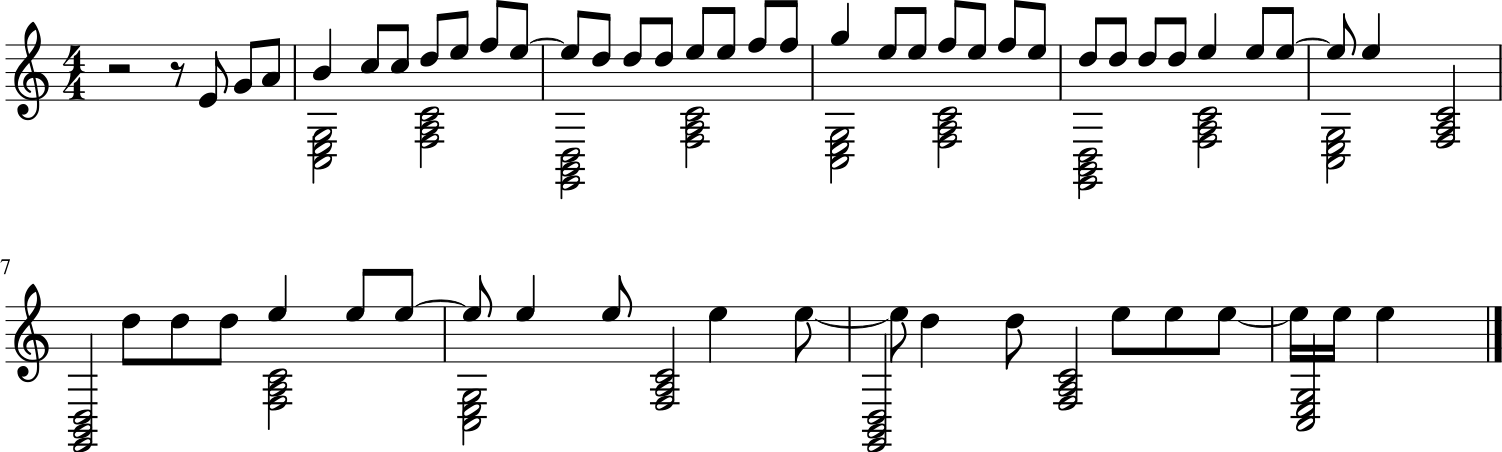

In [88]:
pred_note.show()

In [ ]:
pred_note.play()